- 현 시점, nasdaq100, 환헷지 nasdaq100 중 어느 쪽에 베팅하는 것이 유리한가

In [50]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np

import requests
from bs4 import BeautifulSoup

import sklearn

import requests
import json

import matplotlib.pyplot as plt
import mplcyberpunk
from matplotlib import rc
import seaborn as sns

plt.style.use('cyberpunk')

plt.rcParams['axes.unicode_minus'] = False
rc('font', family='AppleGothic')

from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
import yfinance as yf

- yfinance로 nasdaq100 헷지/언헷지, 원달러 환율, 금 price를 불러온다.
- 원달러 환율은 언헷지<->헷지 갭을 확인하기 위함, 금 price는 경기불확실성에 대한 달러의 안전자산화를 금과 연계하여 확인하기 위함.

In [10]:
import yfinance as yf
kodex_us_nasdaq100_h = yf.Ticker('449190.KS')
kodex_us_nasdaq100 =yf.Ticker('379810.KS')
exc_rate_usdkrw = yf.Ticker('USDKRW=X')
gld = yf.Ticker('GC=F')

In [32]:
kodex_us_nasdaq100_close = kodex_us_nasdaq100.history(period='3y')['Close']
kodex_us_nasdaq100_h_close = kodex_us_nasdaq100_h.history(period='3y')['Close']
exc_rate_usdkrw_close = exc_rate_usdkrw.history(period='3y')['Close']
gld_close = gld.history(period='3y')['Close']

df_close = pd.DataFrame(data={
    'nasdaq100': kodex_us_nasdaq100_close,
    'nasdaq100_h': kodex_us_nasdaq100_h_close,
    'usdkrw': exc_rate_usdkrw_close,
    'gld': gld_close
})

In [33]:
df_close = df_close.dropna()
df_close

,nasdaq100,nasdaq100_h,usdkrw,gld
Date,,,,
2022-12-02,10300.0,9837.409180,1303.250000,1795.900024
2022-12-05,10225.0,9822.563477,1299.170044,1767.400024
2022-12-06,10240.0,9664.214844,1304.369995,1769.300049
2022-12-07,10090.0,9471.227539,1319.709961,1785.500000
2022-12-08,10005.0,9426.692383,1314.099976,1788.699951
...,...,...,...,...
2024-12-19,20550.0,16640.000000,1451.500000,2592.199951
2024-12-20,20355.0,16505.000000,1437.449951,2628.699951
2024-12-23,20805.0,16870.000000,1445.420044,2612.300049


시계열상 자산의 지수적 증감은 시각적인 착시를 주기 때문에 로그 변환 수행.

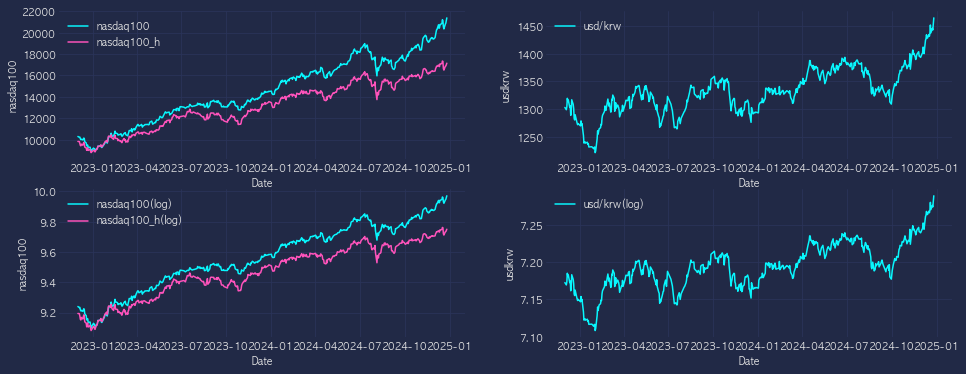

In [184]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,6))

data = df_close
data_log = np.log(df_close)

sns.lineplot(data=data, x=data.index, y='nasdaq100', ax=axes[0,0], label='nasdaq100')
sns.lineplot(data=data, x=data.index, y='nasdaq100_h', ax=axes[0,0], label='nasdaq100_h')

sns.lineplot(data=data, x=data.index, y='usdkrw', ax=axes[0,1], label='usd/krw')

sns.lineplot(data=data_log, x=data_log.index, y='nasdaq100', ax=axes[1,0], label='nasdaq100(log)')
sns.lineplot(data=data_log, x=data_log.index, y='nasdaq100_h', ax=axes[1,0], label='nasdaq100_h(log)')

sns.lineplot(data=data_log, x=data_log.index, y='usdkrw', ax=axes[1,1], label='usd/krw(log)')
plt.show()

- 시계열상 헷지<->언헷지 갭은 달러의 움직임과 일치
- 햇지 대비 언햇지 아웃퍼폼은 환율 상승분과 같다.

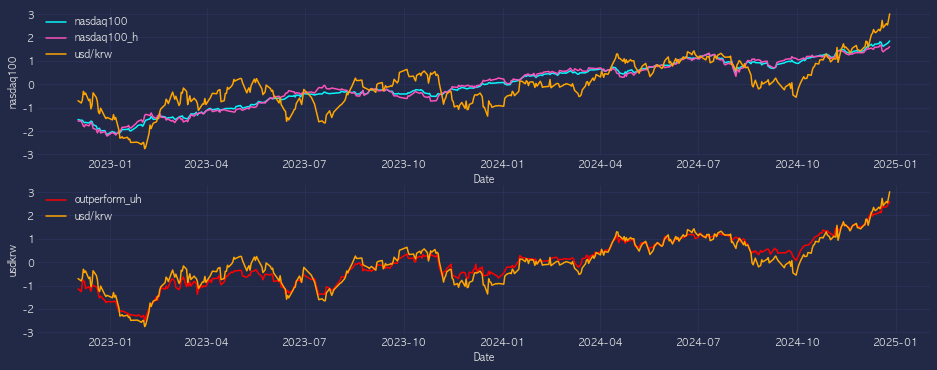

In [81]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16,6))

data_scaled = (data_log - data_log.mean()) / data_log.std()
h_gap = data_log['nasdaq100'] - data_log['nasdaq100_h']
h_gap_scaled = (h_gap - h_gap.mean()) / h_gap.std()

sns.lineplot(data=data_scaled, x=data_scaled.index, y='nasdaq100', ax=axes[0], label='nasdaq100')
sns.lineplot(data=data_scaled, x=data_scaled.index, y='nasdaq100_h', ax=axes[0], label='nasdaq100_h')

sns.lineplot(data=data_scaled, x=data_scaled.index, y='usdkrw', color='orange', ax=axes[0], label='usd/krw')


sns.lineplot(data=h_gap_scaled, ax=axes[1], color='red', label='outperform_uh')
sns.lineplot(data=data_scaled, x=data_scaled.index, y='usdkrw', ax=axes[1], color='orange', label='usd/krw')

plt.show()

현재 원달러 환율은 역사적으로 어떤 상태인가? 높은가? 낮은가?

In [114]:
exc_rate_usdkrw_close_20y = exc_rate_usdkrw.history(period='20y')['Close']
exc_rate_usdkrw_close_20y

Date
2004-12-27    1030.099976
2004-12-28    1043.699951
2004-12-29    1029.800049
2004-12-30    1026.800049
2004-12-31    1002.599976
                 ...     
2024-12-20    1437.449951
2024-12-23    1445.420044
2024-12-24    1442.699951
2024-12-25    1453.420044
2024-12-26    1463.420044
Name: Close, Length: 5189, dtype: float64

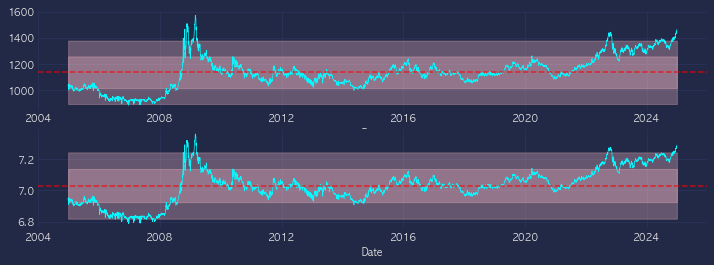

In [120]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12,4))

data = exc_rate_usdkrw_close_20y
sns.lineplot(data=data, x=data.index, y=data.values, linewidth=0.7, ax=axes[0])

axes[0].fill_between(x=data.index, y1=data.mean()-data.std(), y2=data.mean()+data.std(), alpha=0.3, color='pink')
axes[0].fill_between(x=data.index, y1=data.mean()-data.std()*2, y2=data.mean()+data.std()*2, alpha=0.3, color='pink')
axes[0].axhline(y=data.mean(), linestyle='--', alpha=0.7, color='r')

data_log = np.log(data)
sns.lineplot(data=data_log, x=data_log.index, y=data_log.values, linewidth=0.7, ax=axes[1])

axes[1].fill_between(x=data_log.index, y1=data_log.mean()-data_log.std(), y2=data_log.mean()+data_log.std(), alpha=0.3, color='pink')
axes[1].fill_between(x=data_log.index, y1=data_log.mean()-data_log.std()*2, y2=data_log.mean()+data_log.std()*2, alpha=0.3, color='pink')
axes[1].axhline(y=data_log.mean(), linestyle='--', alpha=0.7, color='r')

plt.show()

평균 + 2 표준편차보다 높은 위치. 2008 금융위기때보단 덜하지만, 현재 시점도 충분히 높고, 하방 압력이 강할 수 있는 상태

달러가 강한 상태가 경기사이클에 의한 일시적인 것인지 확인. 
- 금 가격과 연계해서 보자.

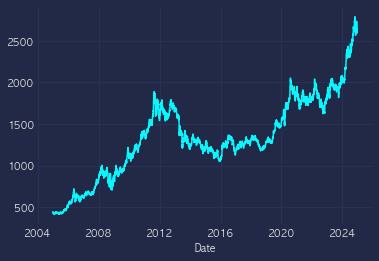

In [182]:
gld_close_20y = gld.history(period='20y')['Close']

data = gld_close_20y
sns.lineplot(data=data, x=data.index, y=data.values)
plt.show()

In [133]:
df_close_20y = pd.DataFrame(data={
    'usdkrw_20y':exc_rate_usdkrw_close_20y,
    'gld_20y': gld_close_20y})
df_close_20y = df_close_20y.dropna()
df_close_20y

,usdkrw_20y,gld_20y
Date,,
2004-12-27,1030.099976,445.200012
2004-12-28,1043.699951,444.299988
2004-12-29,1029.800049,436.000000
2004-12-30,1026.800049,437.500000
2005-01-03,1027.300049,428.700012
...,...,...
2024-12-19,1451.500000,2592.199951
2024-12-20,1437.449951,2628.699951
2024-12-23,1445.420044,2612.300049


In [134]:
df_close_20y.corr()

,usdkrw_20y,gld_20y
usdkrw_20y,1.00000,0.64481
gld_20y,0.64481,1.00000


In [136]:
df_close_20y_log = np.log(df_close_20y)
df_close_20y_log.corr()

,usdkrw_20y,gld_20y
usdkrw_20y,1.000000,0.643239
gld_20y,0.643239,1.000000


In [151]:
years = list(np.arange(2004, 2025, 1))
year_corr_dict = {}
for year in years:
    year_corr_dict[str(year)] = round(df_close_20y_log[str(year)].corr().iloc[1,0],2)

- 연도별 금-원달러환율 상관계수

In [152]:
year_corr_dict

{'2004': 0.57,
 '2005': 0.07,
 '2006': -0.66,
 '2007': -0.28,
 '2008': -0.78,
 '2009': -0.69,
 '2010': -0.09,
 '2011': -0.02,
 '2012': -0.6,
 '2013': -0.01,
 '2014': -0.5,
 '2015': -0.82,
 '2016': -0.7,
 '2017': -0.55,
 '2018': -0.89,
 '2019': 0.7,
 '2020': -0.4,
 '2021': -0.25,
 '2022': -0.85,
 '2023': 0.07,
 '2024': 0.54}

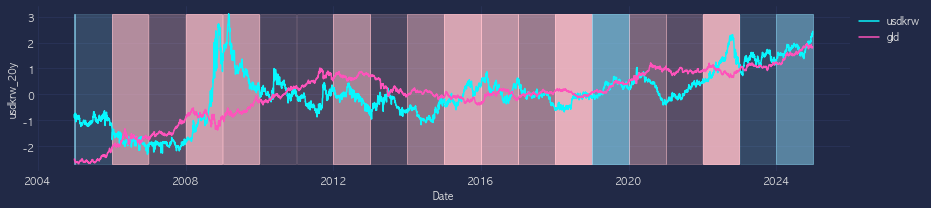

In [186]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12,3))

data = (df_close_20y_log - df_close_20y_log.mean()) / df_close_20y_log.std()
sns.lineplot(data=data, x=data.index, y='usdkrw_20y', label='usdkrw')
sns.lineplot(data=data, x=data.index, y='gld_20y', label='gld')

for year in year_corr_dict.keys():
    if year_corr_dict[year] >= 0:
        color = 'skyblue'
    else:
        color = 'pink'
    
    if abs(year_corr_dict[year]) <= 0.2:
        alpha = 0.2
    else:
        alpha = abs(year_corr_dict[year])
    plt.fill_betweenx(x1=data[year].index[0], 
                      x2=data[year].index[-1], 
                      y=[data.values.min(), data.values.max()], 
                      alpha=alpha, color=color)
    
    
plt.tight_layout()
plt.legend(bbox_to_anchor=(1,1))

plt.show()

- 통상 원달러환율과 금 가격은 디커플링 상태인데, 금이 달러 리스크(가치하락)를 헷지하기 때문.
- 코로나 19 시기와 마찬가지로 경제불황을 염려하여 안전자산을 추구하는 성향이 달러 가치와 금 가격을 동시에 견인하고 있음.
    - 다만, 2008년 금융위기는 대량 마진콜로 인한 금 매도, 안전자산 수요에 따른 달러 매수가 동시에 발생하며 다소 다른 양상을 보임.
- 따라서, 강한 경제불황 염려 이벤트로 일시적인 원달러 환율-금 가격 커플링 상태에 있으며, 디커플링으로 전환시 현재의 높은 달러 가격은 하락할 가능성이 높음.